### Implementing logistic regression from scratch

#### The goal of this project is to
- Implement logistic regression with gradiant descent from scratch 
- perform sentiment analysis on curated Amazon review data.

The project is developed upon a project for classification class from UW on Coursera. 

A subset of the Amazon product review dataset is provided as class materials in csv format. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

#### Emma Yu, Sep 2016

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8., 10.0) 

First, let's read the data into a Pandas dataframe. There are 53072 rows and 4 columns of the data. Each row contains a review for a baby project on Amazon, and each row includes 

- the product name ('name')
- the review in original text form ('review')
- the customer rating ("rating", ranging from 1 to 5 with 5 being the highest)
- a label denoting whether the review is positive or negative ("sentiment", 1 means positive, and -1 means negative).


In [2]:
df = pd.read_csv('amazon_baby_subset.csv', skiprows =1, names = ['name','review','rating','sentiment']) 

In [3]:
df.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [4]:
print df.dtypes
print df.describe()

name         object
review       object
rating        int64
sentiment     int64
dtype: object
             rating     sentiment
count  53072.000000  53072.000000
mean       3.097490      0.001620
std        1.730509      1.000008
min        1.000000     -1.000000
25%        1.000000     -1.000000
50%        4.000000      1.000000
75%        5.000000      1.000000
max        5.000000      1.000000


In [5]:
print 'number of positive items: ',df[df.sentiment == 1].sentiment.count()
print 'number of negative items: ',df[df.sentiment == -1].sentiment.count()

number of positive items:  26579
number of negative items:  26493


We can see as described in the problem setup, the number of positive and negative items are about the same. 

The "sentiment" column is actually generated from "rating" in previous data cleaning processes. We removed neutral ratings (rating = 3), and decided to consider reviews with rating 1-2 as negative, and 4-5 as positive.

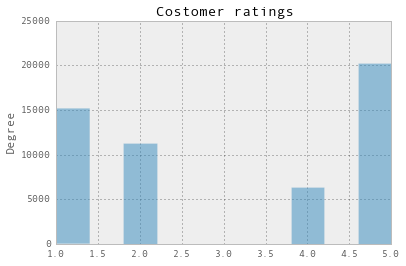

In [6]:
pd.options.display.mpl_style = 'default'
df['rating'].plot( x='Rating', y='Count', kind='hist', alpha=0.5, title='Costomer ratings')

### Data cleaning
Before we dive into the review data, let's first deal with some missing entreis (n/a), and remove functuation for the ease of further processing. 

In [7]:
# fill in nas in the review column
df = df.fillna({'review':''})  

In [8]:
# let's use pandas translate to map all punctuations into empty strings
import string
df['review_clean'] = df['review'].apply(lambda x: x.translate(string.maketrans("",""), string.punctuation))

In [9]:
# print the first 5 entries to make sure the puncutation has been successfully removed
df['review_clean'].iloc[0:5]

0    All of my kids have cried nonstop when I tried...
1    We wanted to get something to keep track of ou...
2    My daughter had her 1st baby over a year ago S...
3    One of babys first and favorite books and it i...
4    Very cute interactive book My son loves this b...
Name: review_clean, dtype: object

### Feature extraction
Let's build bag-of-words features for the 193 most frequent words (the list of words is provided for this assignment). 

In [10]:
# first read in the list of word from json file. 
import json
with open('important_words.json') as data_file:    
    important_words = json.load(data_file)

In [11]:
# print out the first 5 entries to check
important_words[0:5]

[u'baby', u'one', u'great', u'love', u'use']

In [12]:
# now let's do word counts for all the reviews
for word in important_words:
    df[word] = df['review_clean'].apply(lambda s : s.split().count(word))

In [13]:
# Now we should have one column for each word count. Let's check the dimension of the dataframe
# to confirm this.
df.shape

(53072, 198)

In [14]:
# Let's look at one word as an example, say, how many reviews contain the word perfect?
df['perfect'].apply(lambda count: 1 if count>0 else 0).sum()

2955

To make our later operations more efficient, let's convert our count data into a numpy array:

In [15]:
def get_numpy_data(dataframe, features, label):
    '''  
    Input: 
    dataframe - every row contains one data, and each feature is a column in the data frame
    features - a list of string of feature names
    lable - name of the class label column
    
    return
    - a 2D array contains the values for every feature and a column of 1 for fitting the intercept
    - a 1D array of the class values
    
    '''
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [16]:
feature_matrix, sentiment = get_numpy_data(df, important_words, 'sentiment')

In [17]:
feature_matrix.shape

(53072, 194)

In [18]:
sentiment.shape

(53072,)

### Construct the logistic regression model

In [19]:
def predict_probability(feature_matrix, coefficients):
    ''' 
    compute the probability of prediction 1s given feature matrix
    and coefficients with a logic link.
    
    return a vector - one probability for each data point
    '''
    
    score = np.dot(feature_matrix, coefficients)
    predictions = 1./(1.+np.exp(-score))
    return predictions

In [25]:
def feature_derivative(errors, feature):     
    ''' 
    Compute the derivative given a column of errors and a column of feature
    '''
    derivative = np.dot(errors, feature).sum()

    return derivative


In [26]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    ''' 
    Compute the log-likelihood function for logistic regression
    not sure about this one. need double check
    '''
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

In [27]:
def logistic_regression(feature_matrix, sentiment, init_coefficients, stepsize, max_iter):
    '''
    Do we actually need the likelihood function for anything?
    '''
    coeff = init_coefficients
    pred = predict_probability(feature_matrix, coeff)
    # let's figure out how to calculate the error 
    errors = (sentiment==+1)-pred
    print 'total errors = ',np.sum(errors)
    
    for i in range(max_iter):
        totalpartial = 0
        for j in range(len(important_words)+1):
            # gredient ascent on one dimension
            partial = feature_derivative(errors, feature_matrix[:,j])
            coeff[j] += stepsize*partial
            totalpartial += partial**2
            # calculate the new prediction and error
            
        pred = predict_probability(feature_matrix, coeff)
        errors = (sentiment==+1)-pred
            
            # exit condition <- need some work
        if totalpartial <= 1e-5: 
            print 'exit after', i ,'iterations'
            return coeff, pred
        
    return coeff, pred

In [33]:
coeff, pred = logistic_regression(feature_matrix, sentiment, np.zeros(len(important_words)+1), 1e-7, 301)

total errors =  43.0


(array([  1.,   4.,  11.,  60.,  82.,  27.,   4.,   0.,   2.,   3.]),
 array([-0.05386015, -0.04181953, -0.0297789 , -0.01773828, -0.00569766,
         0.00634297,  0.01838359,  0.03042421,  0.04246484,  0.05450546,
         0.06654608]),
 <a list of 10 Patch objects>)

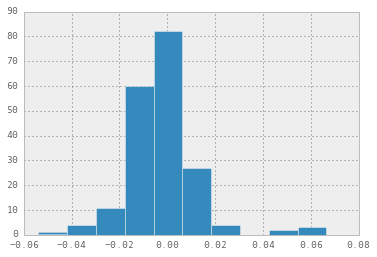

In [34]:
plt.hist(coeff)

In [35]:
# number of reviews that are predicted as positive
pos = (pred>=0.5)
np.sum(pos)

25126

In [46]:
# What about the accuracy?
sentpos = (sentiment==+1)
agree = (pos == sentpos)
print np.sum(agree)
print (np.sum(agree)+0.0)/agree.shape[0]


39903
0.751865390413


In [38]:
# Let's sort the word list by weight
sindex = coeff.argsort()
# note that the weight array includes the intercept. Let's add an empty string to count for that.
full_words = np.array([' '] +important_words) 
sorted_words = full_words[sindex]

In [71]:
# print the top 10 negative words
#sorted_words[0:10]
#sorted_words[-10:]

def plot_top_words(num, twords, wprob, title):
    matplotlib.rcParams['figure.figsize'] = (12, 8.0) 
    plt.bar(range(num), wprob, 0.6)
    plt.xticks(range(num), twords)
    plt.tick_params(labelsize=15)
    plt.title(title, fontsize=20)
    plt.show()


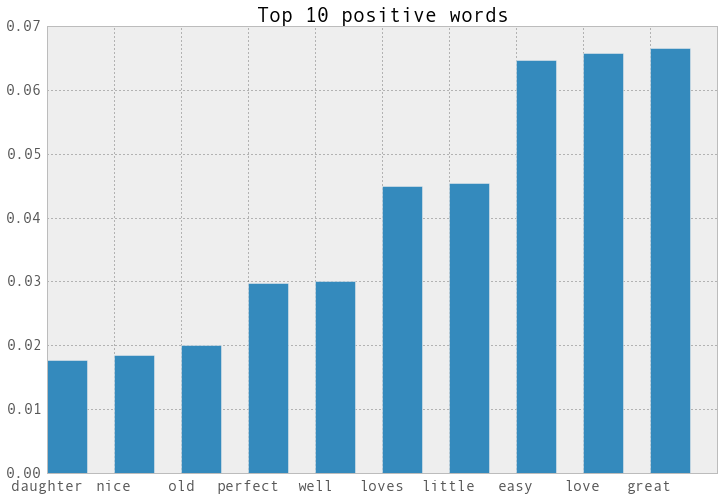

In [72]:
plot_top_words(10, sorted_words[-10:], coeff[sindex][-10:],'Top 10 positive words')

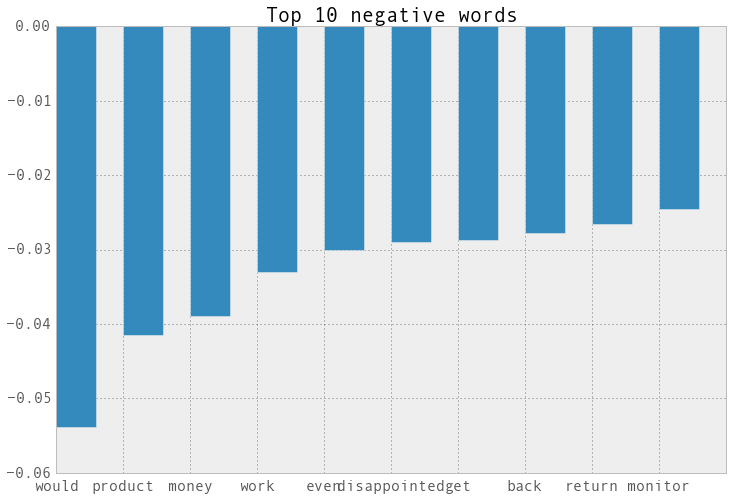

In [73]:
plot_top_words(10, sorted_words[0:10], coeff[sindex][0:10],'Top 10 negative words')

### Now let's add some regularization to prevent over-fitting